# Module 8: 時間序列特徵工程 - 3. 日期與時間特徵 (Date and Time Features)

## 學習目標
- 理解日期與時間特徵的重要性，及其如何從原始時間戳中揭示週期性模式和規律。
- 學習並實作如何使用 `pandas` 的 `.dt` 訪問器，從時間序列索引或欄位中提取多種時間組件（如年、月、日、時、分、星期幾、季度等）。
- 掌握如何透過箱形圖 (Boxplot) 等視覺化工具，分析時間特徵與目標變數之間的關係，發現潛在模式。
- 學習並實作如何處理週期性時間特徵（如小時、月份）的編碼，使用正弦/餘弦變換避免模型誤解其環形性質。
- 了解日期與時間特徵如何與滯後特徵、滑動窗口特徵結合，構建更全面的時間序列預測模型。

## 導論：如何將時間的「日曆」與「時鐘」資訊轉化為模型洞察？

在處理時間序列資料時，除了從過去的數值中提取滯後和滑動窗口特徵外，時間序列本身的日期和時間屬性也蘊藏著豐富的預測信息。這些信息包括但不限於年份、月份、日期、小時，甚至星期幾、季度或是一年中的第幾天。這些看似簡單的資訊，卻是揭示資料中**週期性模式 (Cyclical Patterns)** 和**規律性 (Regularities)** 的關鍵。

指南強調：「*日期時間特徵對於捕捉資料中的週期性模式（如季節性、星期幾效應、假日效應等）至關重要。*」這正是本章節的核心。許多現實世界的現象都表現出明顯的週期性行為：例如，電力消耗在夏季和冬季通常較高；交通流量在工作日和週末有顯著差異；網站的訪問量在一天中的白天和晚上會呈現不同的模式。這些可預測的波動，若能被轉化為清晰的特徵，將極大地提升機器學習模型的預測準確性。

**日期與時間特徵的應用情境**：
-   **識別季節性 (Seasonality)**：例如，分析服裝銷量隨月份變化的趨勢，或旅遊業在不同季節的客流量。
-   **捕捉周循環 (Weekly Cycle)**：例如，零售店在週末的銷售高峰，或物流公司在工作日的貨運量。
-   **發現日循環 (Daily Cycle)**：例如，線上服務在特定時段（如午餐時間、下班後）的使用高峰。
-   **處理假日效應 (Holiday Effect)**：識別特定日期（如聖誕節、國定假日）對業務指標的特殊影響。

本節將深入探討如何利用 `pandas` 強大的 `.dt` 訪問器，從時間戳中提取這些多樣化的日期與時間特徵，並討論如何將它們有效地納入您的機器學習模型。

---

## 1. 載入套件與資料

為了清晰地演示日期與時間特徵的提取過程，我們將使用電力消耗資料集。這個資料集包含時間戳和對應的電力消耗量，且通常具備顯著的日、週、月、年週期性，是展示時間特徵提取的理想數據。我們將確保數據載入的穩健性，並將時間戳設置為 DataFrame 的索引。

**請注意**：此處預設資料檔案為 `household_power_consumption.txt`，請確保您已從 [Kaggle](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set) 下載並放置在 `../../datasets/raw/power_consumption/` 路徑下。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 資料路徑
DATASET_PATH_TXT = '../../../../datasets/raw/power_consumption/household_power_consumption.txt'

# 檢查資料是否存在，若不存在則創建一個虛擬資料集
if not os.path.exists(DATASET_PATH_TXT):
    print(f"錯誤：找不到 '{DATASET_PATH_TXT}' 檔案。")
    print(f"請確認您已將資料下載至 '{os.path.abspath(DATASET_PATH_TXT)}'")
    print("將創建一個虛擬資料集用於演示。")
    date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='H') # 以小時頻率創建虛擬數據
    dummy_data = np.random.randn(len(date_rng)).cumsum() + 15000
    df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_MW'])
else:
    print(f"正在從 '{DATASET_PATH_TXT}' 載入電力消耗資料...")
    try:
        # 由於原始資料格式為分號分隔，且包含日期時間需要合併解析，還有缺失值需要處理
        df_power_raw = pd.read_csv(
            DATASET_PATH_TXT, 
            sep=';', 
            parse_dates={'Datetime': ['Date', 'Time']},
            index_col='Datetime',
            na_values=['?'],
            low_memory=False # 避免 dtype warning，但會增加記憶體使用
        )
        print("原始電力消耗資料載入成功！")

        # 選擇 'Global_active_power' 列並重命名
        if 'Global_active_power' in df_power_raw.columns:
            df_power = df_power_raw[['Global_active_power']].copy()
            df_power.rename(columns={'Global_active_power': 'Consumption_MW'}, inplace=True)
            # 將數據類型轉換為數值，並去除 NaN
            df_power['Consumption_MW'] = pd.to_numeric(df_power['Consumption_MW'], errors='coerce')
            df_power.dropna(inplace=True)
            print("電力消耗資料已成功處理！")
            print(f"處理後資料集形狀: {df_power.shape}")
            display(df_power.head())
        else:
            print("錯誤：'Global_active_power' 欄位不存在。將創建一個虛擬資料集。")
            date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='H') # 以小時頻率創建虛擬數據
            dummy_data = np.random.randn(len(date_rng)).cumsum() + 15000
            df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_MW'])
            print("虛擬資料集創建完成！")
    except Exception as e:
        print(f"載入或處理資料時發生錯誤: {e}。將創建一個虛擬資料集。")
        date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='H') # 以小時頻率創建虛擬數據
        dummy_data = np.random.randn(len(date_rng)).cumsum() + 15000
        df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_MW'])
        print("虛擬資料集創建完成！")

# 確保 df_power 不是空的 DataFrame 才顯示 head
if not df_power.empty:
    print("原始電力消耗資料 (前5筆):")
    display(df_power.head())


Matplotlib and Seaborn styles configured.
正在從 '../../../../datasets/raw/power_consumption/household_power_consumption.txt' 載入電力消耗資料...


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_51176\3264186985.py:31: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_power_raw = pd.read_csv(


原始電力消耗資料載入成功！
電力消耗資料已成功處理！
處理後資料集形狀: (2049280, 1)


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_51176\3264186985.py:31: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_power_raw = pd.read_csv(


,Consumption_MW
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


原始電力消耗資料 (前5筆):


,Consumption_MW
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


**結果解讀**：

我們已經成功載入並處理了電力消耗數據。現在，DataFrame 以 `DatetimeIndex` 為索引，包含單一的 `Consumption_MW` 欄位。這正是我們提取日期時間特徵的理想格式。電力消耗數據通常具有顯著的每日、每週和季節性模式，這些模式將是我們接下來提取和分析的重點。

## 2. 創建日期時間特徵：分解時間的維度

`pandas` 為其 `DatetimeIndex` 對象提供了一個特殊的 `.dt` 訪問器，讓您可以非常簡潔地從時間戳中提取出各種時間組件。這些組件包括年份、月份、日期、小時、分鐘，以及更具週期性的星期幾、季度、一年中的第幾天/週等。將這些時間信息轉換為數值特徵，可以幫助機器學習模型理解並利用時間序列中的週期性。

In [9]:
df_power

,Datetime,Consumption_MW
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
2049275,2010-11-26 20:58:00,0.946
2049276,2010-11-26 20:59:00,0.944
2049277,2010-11-26 21:00:00,0.938
2049278,2010-11-26 21:01:00,0.934


In [ ]:
print("正在從時間索引中提取日期與時間特徵...")

def create_datetime_features(df, datetime_col='index'):
    """
    從 DataFrame 的日期時間索引或指定欄位中創建多種時間特徵。
    參數：
    - df: 輸入的 pandas DataFrame。
    - datetime_col: 指定日期時間欄位名稱，或 'index' 表示使用 DataFrame 的索引。
    返回：
    - 包含新增時間特徵的 DataFrame。
    """
    df = df.reset_index()
    if datetime_col == 'index':
        time_series = pd.to_datetime(df['index'])
    else:
        time_series = pd.to_datetime(df[datetime_col])

    # 直接用 Series 的 .dt 屬性提取時間特徵
    df['hour'] = time_series.dt.hour
    df['dayofweek'] = time_series.dt.dayofweek # 星期幾 (0=週一, 6=週日)
    df['dayofmonth'] = time_series.dt.day # 月中的第幾天
    df['dayofyear'] = time_series.dt.dayofyear # 年中的第幾天
    df['weekofyear'] = time_series.dt.isocalendar().week.astype(int) # 年中的第幾週 (轉換為 int)
    df['month'] = time_series.dt.month
    df['quarter'] = time_series.dt.quarter
    df['year'] = time_series.dt.year
    
    # 建立布林特徵，判斷是否為週末
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int) # 1 if weekend, 0 otherwise
    
    return df

# 應用函數到電力消耗資料集
df_featured = create_datetime_features(df_power.copy(), datetime_col='Datetime')


正在從時間索引中提取日期與時間特徵...


In [19]:
print("日期與時間特徵創建完成！")
print("加入日期時間特徵後的資料 (前5筆，部分欄位)：")
display(df_featured[['Consumption_MW', 'hour', 'dayofweek', 'month', 'year', 'is_weekend']].head())

日期與時間特徵創建完成！
加入日期時間特徵後的資料 (前5筆，部分欄位)：


,Consumption_MW,hour,dayofweek,month,year,is_weekend
0,4.216,17,5,12,2006,1
1,5.360,17,5,12,2006,1
2,5.374,17,5,12,2006,1
3,5.388,17,5,12,2006,1
4,3.666,17,5,12,2006,1


**結果解讀與討論**：

現在，我們的 `df_featured` DataFrame 包含了從時間索引中提取出的多個新特徵。例如，`hour` 欄位代表了一天中的小時數，`dayofweek` 代表了星期幾。這些特徵將原始時間戳的複雜性轉化為模型可以直接利用的數值和類別信息。例如，模型可以透過 `hour` 學習到一天中不同時段的電力消耗模式，或透過 `dayofweek` 學習工作日與週末的差異。

## 3. 視覺化時間特徵與目標變數的關係：揭示隱藏的週期模式

創建了日期與時間特徵之後，一個至關重要的步驟是通過視覺化來探索這些新特徵與我們的目標變數（電力消耗）之間是否存在顯著的關係。箱形圖 (Boxplot) 是一個非常適合用於展示數值變數在不同類別（例如，不同月份、不同星期幾、不同小時）下的分佈和中心趨勢的工具。透過這些圖表，我們可以直觀地發現資料中的週期性模式和潛在的預測信號。

In [35]:
# set(df_featured["Datetime"].dt.year)

df_featured.index = pd.to_datetime(df_featured['Datetime'])

df_featured

,Datetime,Consumption_MW,hour,dayofweek,dayofmonth,dayofyear,weekofyear,month,quarter,year,is_weekend
Datetime,,,,,,,,,,,
2006-12-16 17:24:00,2006-12-16 17:24:00,4.216,17,5,16,350,50,12,4,2006,1
2006-12-16 17:25:00,2006-12-16 17:25:00,5.360,17,5,16,350,50,12,4,2006,1
2006-12-16 17:26:00,2006-12-16 17:26:00,5.374,17,5,16,350,50,12,4,2006,1
2006-12-16 17:27:00,2006-12-16 17:27:00,5.388,17,5,16,350,50,12,4,2006,1
2006-12-16 17:28:00,2006-12-16 17:28:00,3.666,17,5,16,350,50,12,4,2006,1
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,2010-11-26 20:58:00,0.946,20,4,26,330,47,11,4,2010,0
2010-11-26 20:59:00,2010-11-26 20:59:00,0.944,20,4,26,330,47,11,4,2010,0
2010-11-26 21:00:00,2010-11-26 21:00:00,0.938,21,4,26,330,47,11,4,2010,0


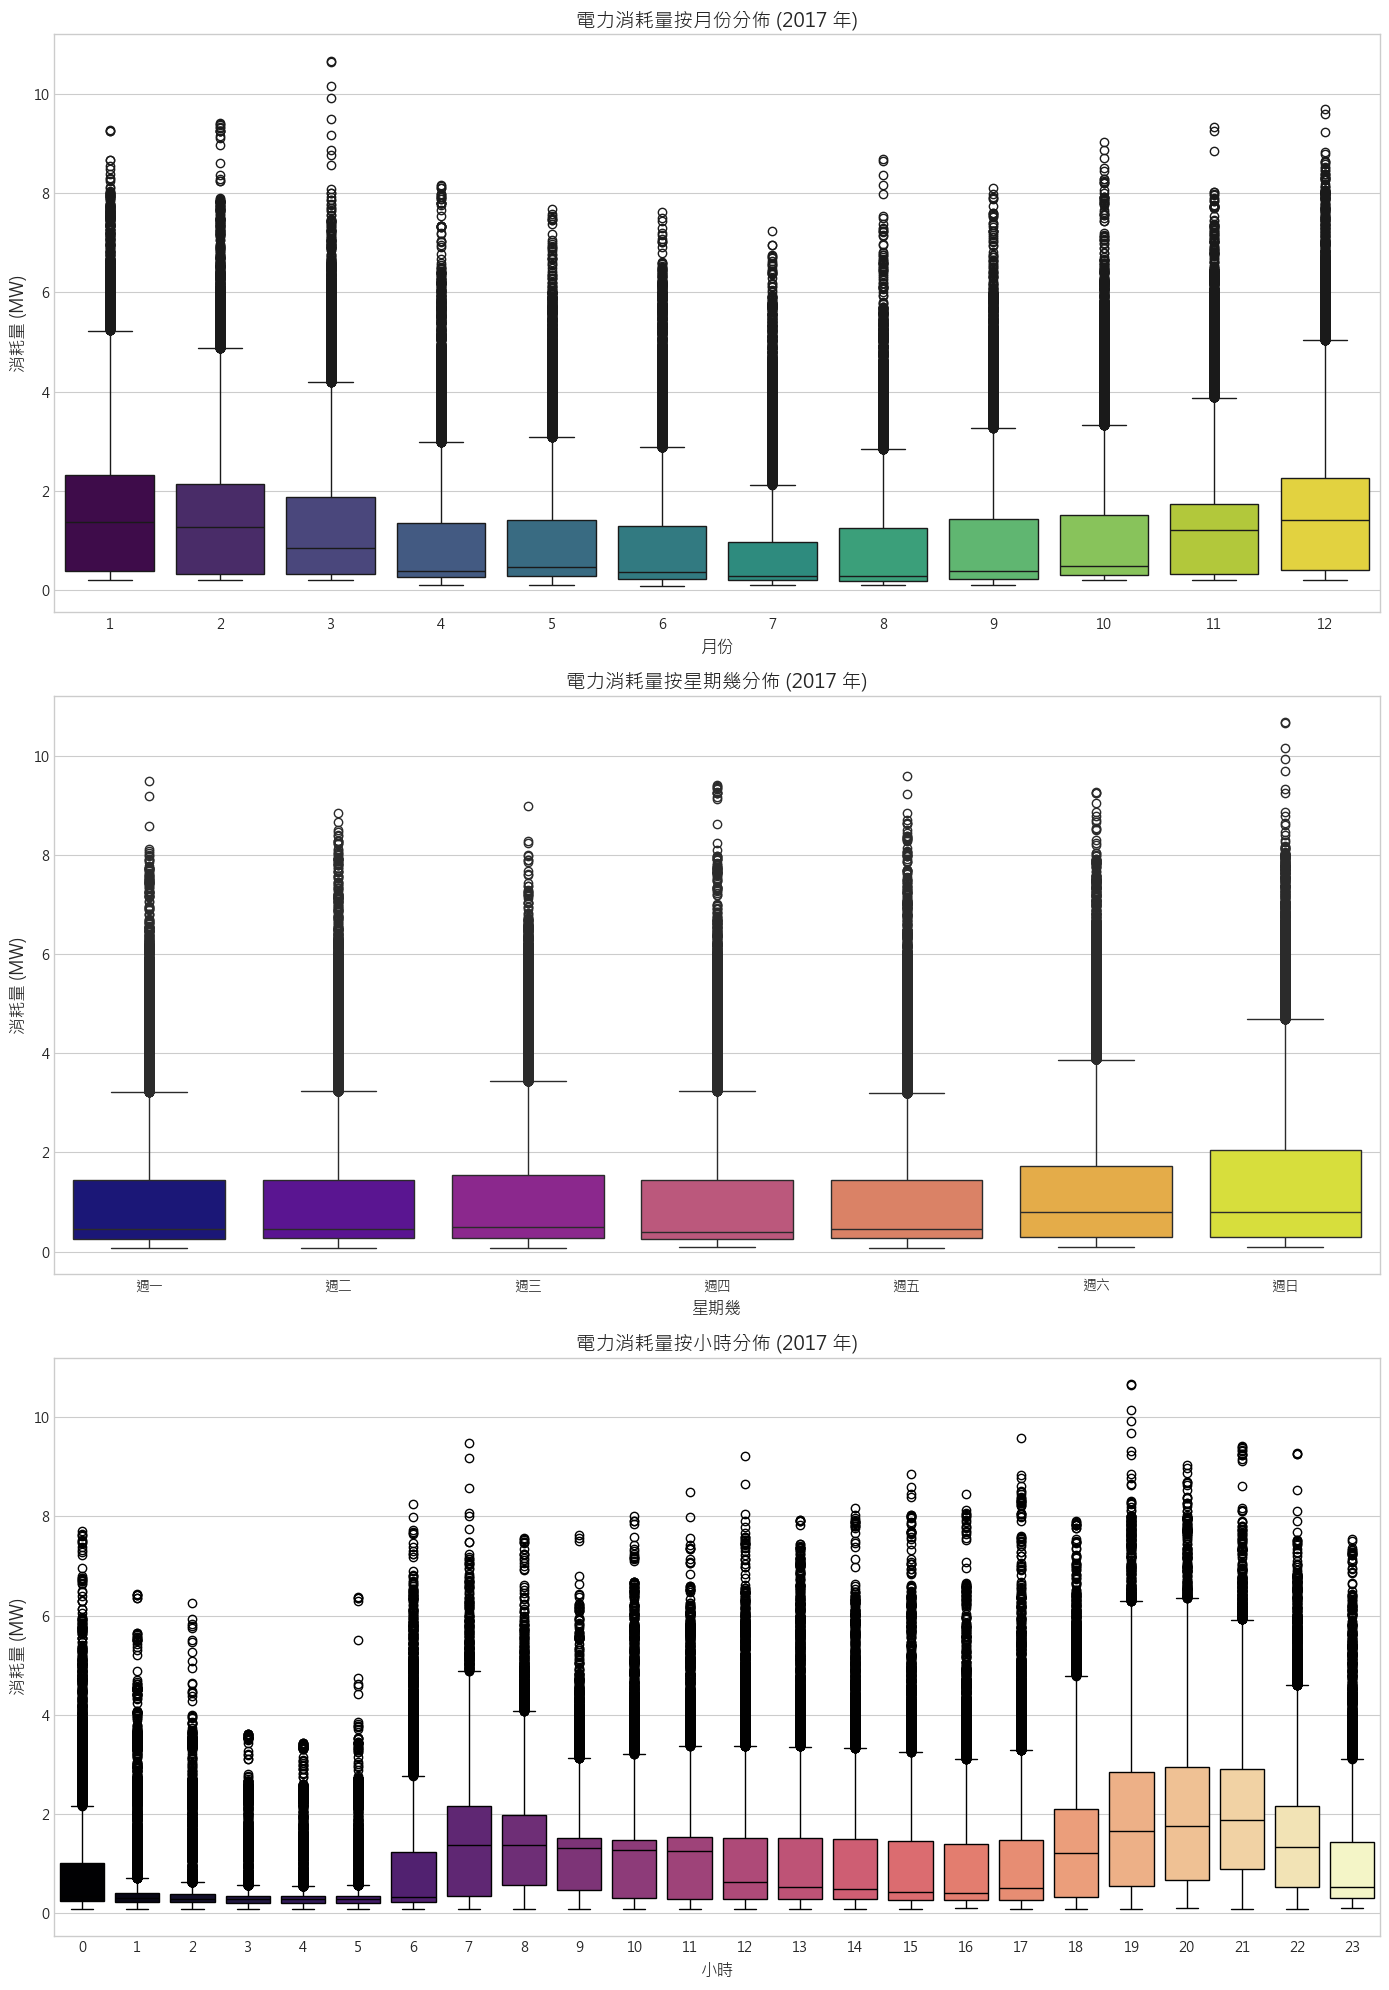

In [39]:
# 為了讓視覺化更清晰，我們使用電力消耗資料中一年的數據 (例如 2007 年)
df_plot = df_featured.loc['2007']

fig, axes = plt.subplots(3, 1, figsize=(14, 20)) # 創建 3 行 1 列的子圖

# 月份 vs. 消耗量：觀察季節性模式
sns.boxplot(data=df_plot, x='month', y='Consumption_MW', ax=axes[0], hue='month', palette='viridis', legend=False)
axes[0].set_title('電力消耗量按月份分佈 (2017 年)', fontsize=14)
axes[0].set_xlabel('月份', fontsize=12)
axes[0].set_ylabel('消耗量 (MW)', fontsize=12)

# 星期幾 vs. 消耗量：觀察周循環模式
sns.boxplot(data=df_plot, x='dayofweek', y='Consumption_MW', ax=axes[1], hue='dayofweek', palette='plasma', legend=False)
axes[1].set_title('電力消耗量按星期幾分佈 (2017 年)', fontsize=14)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['週一', '週二', '週三', '週四', '週五', '週六', '週日'], fontsize=10)
axes[1].set_xlabel('星期幾', fontsize=12)
axes[1].set_ylabel('消耗量 (MW)', fontsize=12)

# 小時 vs. 消耗量：觀察日循環模式
sns.boxplot(data=df_plot, x='hour', y='Consumption_MW', ax=axes[2], hue='hour', palette='magma', legend=False)
axes[2].set_title('電力消耗量按小時分佈 (2017 年)', fontsize=14)
axes[2].set_xlabel('小時', fontsize=12)
axes[2].set_ylabel('消耗量 (MW)', fontsize=12)

plt.tight_layout() # 自動調整子圖參數，使之填充整個圖形區域
plt.show()



### 視覺化分析與討論：

從上方的箱形圖中，我們可以觀察到清晰且預期中的電力消耗模式，這些都是非常有價值的預測信號：

1.  **月份 (季節性)**：電力消耗在夏季（約 6-8 月，由於空調需求）和冬季（約 12-1 月，由於取暖需求）顯著更高。這表明月份是捕捉季節性模式的關鍵特徵。
2.  **星期幾 (周循環)**：週末（週六、週日）的電力消耗明顯低於工作日。這可能是因為工業和商業活動在週末減少，而住宅用電模式發生變化。這強調了 `dayofweek` 的重要性。
3.  **小時 (日循環)**：電力消耗在一天中呈現出明顯的雙峰模式。一個小高峰出現在上午（人們開始工作），一個大高峰出現在傍晚（下班回家後的高峰用電時段，例如晚餐準備和娛樂）。凌晨時段的消耗最低。這說明 `hour` 特徵對於捕捉每日的行為規律至關重要。

這些模式都提供了強大的預測信號。機器學習模型可以利用這些提取出的日期與時間特徵，來學習和預測這些可預見的波動，從而顯著提升預測的準確性。

## 4. 處理週期性特徵：將「環形」數據線性化

像 `hour`（小時，0-23）和 `month`（月份，1-12）這樣的特徵本質上是週期性的，或稱「環形」的。例如，23 點之後是 0 點，12 月之後是 1 月。如果我們直接將它們作為普通的數值特徵（如 0, 1, 2, ..., 23 或 1, 2, ..., 12）輸入模型，可能會誤導模型，因為模型會認為 23 和 0 之間、或 12 和 1 之間的「距離」很大，而實際上它們在週期上是相鄰的。這種對「距離」的錯誤理解可能會導致模型學習到不正確的關係。

解決這個問題的一種常見且有效的方法是使用正弦 (sine) 和餘弦 (cosine) 變換將這些週期性特徵轉換為兩個連續的、可以捕捉其週期性關係的特徵。這個轉換將單一的週期性數值映射到二維空間的一個圓上，使得週期的開始和結束點在空間上是相鄰的。

$$ X_{sin} = \sin(2 \pi \frac{X}{X_{max}}) $$
$$ X_{cos} = \cos(2 \pi \frac{X}{X_{max}}) $$

其中，$X$ 是原始的週期性特徵值，$X_{max}$ 是該週期的最大值（例如，小時為 23，月份為 12，星期幾為 6）。

正在對週期性特徵進行正弦/餘弦編碼...
週期性特徵編碼完成！
加入週期性編碼後的資料 (前5筆，部分欄位)：


,hour,hour_sin,hour_cos,dayofweek,dayofweek_sin,dayofweek_cos,month,month_sin,month_cos
Datetime,,,,,,,,,
2006-12-16 17:24:00,17,-0.997669,-0.068242,5,-0.866025,0.5,12,-2.449294e-16,1.0
2006-12-16 17:25:00,17,-0.997669,-0.068242,5,-0.866025,0.5,12,-2.449294e-16,1.0
2006-12-16 17:26:00,17,-0.997669,-0.068242,5,-0.866025,0.5,12,-2.449294e-16,1.0
2006-12-16 17:27:00,17,-0.997669,-0.068242,5,-0.866025,0.5,12,-2.449294e-16,1.0
2006-12-16 17:28:00,17,-0.997669,-0.068242,5,-0.866025,0.5,12,-2.449294e-16,1.0


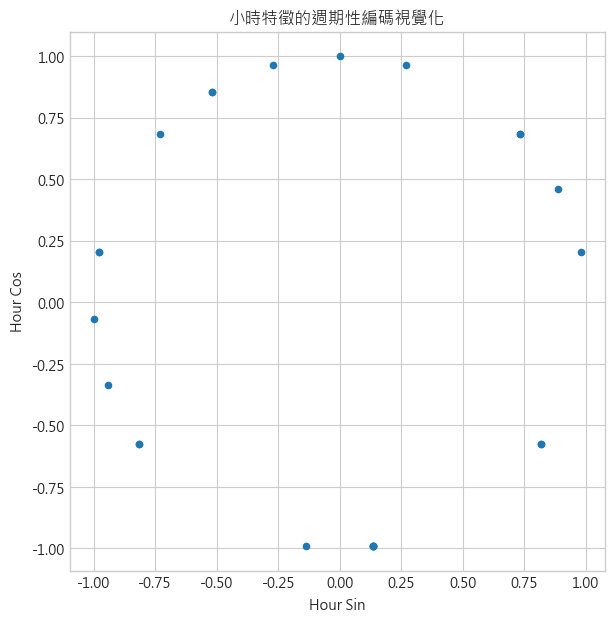

In [40]:
print("正在對週期性特徵進行正弦/餘弦編碼...")
def encode_cyclical_features(df, col, max_val):
    """
    使用正弦和餘弦變換對週期性特徵進行編碼。
    參數：
    - df: 輸入的 DataFrame。
    - col: 要編碼的週期性特徵欄位名稱。
    - max_val: 該週期性特徵的最大值（例如，小時的最大值是23，則max_val=23）。
    返回：
    - 包含新增正弦和餘弦特徵的 DataFrame。
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# 對 'hour' 特徵進行編碼 (最大值為 23，表示 0-23 小時共 24 個點)
df_featured = encode_cyclical_features(df_featured, 'hour', 23)
# 對 'dayofweek' 特徵進行編碼 (最大值為 6，表示 0-6 共 7 個點)
df_featured = encode_cyclical_features(df_featured, 'dayofweek', 6)
# 對 'month' 特徵進行編碼 (最大值為 12，表示 1-12 月共 12 個點)
df_featured = encode_cyclical_features(df_featured, 'month', 12)

print("週期性特徵編碼完成！")
print("加入週期性編碼後的資料 (前5筆，部分欄位)：")
display(df_featured[['hour', 'hour_sin', 'hour_cos', 'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'month', 'month_sin', 'month_cos']].head())

# 視覺化編碼結果，以 'hour' 為例，觀察其在圓上的映射
plt.figure(figsize=(7, 7))
df_featured.sample(24).plot.scatter('hour_sin', 'hour_cos', ax=plt.gca())
plt.title('小時特徵的週期性編碼視覺化')
plt.xlabel('Hour Sin')
plt.ylabel('Hour Cos')
plt.gca().set_aspect('equal') # 保持X和Y軸比例一致，使圓形看起來是圓的
plt.grid(True)
plt.show()



**結果解讀與討論**：

經過正弦/餘弦變換後，每個週期性特徵都被轉換為兩個新的連續數值特徵。例如，`hour_sin` 和 `hour_cos` 共同定義了小時在一個圓上的位置。這樣，23 點和 0 點在新的二維空間中就變得非常接近，有效解決了模型對週期性數據「距離」的誤解。這種編碼對於使用線性模型或類神經網路等對輸入特徵的線性關係敏感的模型尤為重要，能夠幫助它們更好地捕捉時間的週期性模式。

## 5. 總結：時間序列中的「日曆」與「時鐘」智慧

日期與時間特徵是時間序列特徵工程中不可或缺的一環，它允許我們從原始的時間戳中提取出豐富的、具備預測價值的週期性和規律性信息。這些特徵與前面學習的滯後特徵和滑動窗口特徵相輔相成，共同為機器學習模型構建了全面的時間上下文，從而顯著提升了時間序列預測任務的性能。

本節我們學習了以下核心知識點：

| 概念/方法 | 核心作用 | 實作工具/考量點 |
|:---|:---|:---|
| **日期時間特徵提取** | 從時間戳中分解出年、月、日、時、週等組件 | `pandas.Series.dt` 訪問器 |
| **模式視覺化** | 透過箱形圖等展示時間特徵與目標變數關係 | `seaborn.boxplot()`，觀察季節性、日/周循環 |
| **週期性編碼** | 將環形特徵轉換為連續且能表示週期性的形式 | 正弦/餘弦變換 (`np.sin`, `np.cos`)，避免模型誤解 |

在實際應用中，日期與時間特徵的創建應深度結合業務場景和對時間規律的理解。例如，對於一個預測零售銷量的模型，除了常見的年、月、日特徵，還可以考慮添加「是否為節假日」、「距離最近節假日的天數」等更具業務洞察力的時間特徵。透過靈活運用這些技巧，我們可以充分釋放時間資料的潛在預測力量.